### Условие задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### 1. Загрузка данных.

In [163]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2 , f_classif
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,plot_roc_curve, precision_score, recall_score, auc , roc_curve
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

In [164]:
# Путь к файлам проекта
PATH = r"C:\Users\ivan\YandexDisk\DS\Project_Final\Final_project"
#PATH ='/datasets/final_provider/' 

# Записываем датасеты в переменные
df_contract = pd.read_csv(os.path.join(PATH,'contract.csv'))
df_internet = pd.read_csv(os.path.join(PATH,'internet.csv'))
df_personal = pd.read_csv(os.path.join(PATH,'personal.csv'))
df_phone = pd.read_csv(os.path.join(PATH,'phone.csv'))

**Данные по договорам**

In [165]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [166]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [167]:
#  Проверка наличия дубликатов
df_contract.duplicated().sum()

0

**Данные по использованию интернета**

In [168]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [169]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [170]:
#  Проверка наличия дубликатов
df_internet.duplicated().sum()

0

**Данные по абонентам**

In [171]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [172]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [173]:
#  Проверка наличия дубликатов
df_personal.duplicated().sum()

0

**Данные по использованию телефона**

In [174]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [175]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [176]:
#  Проверка наличия дубликатов
df_phone.duplicated().sum()

0

### Выводы:
1. **Contract**. Пропусков и дубликатов нет. Необходимо заменить тип данных в столбцах *BeginDate, EndDate* на **DateTime** и столбца *TotalCharges* на **float**.
2. **Internet**. Пропусков и дубликатов нет. Тип данных соответствует содержанию. Для использования в модели бинарные значения будут преобразованы в 0 и 1.
3. **Personal**. Пропусков и дубликатов нет. Тип данных соответствует содержанию. Непонятен смысл столбцов *SeniorCitizen, Partner, Dependents*.
4. **Phone**. Пропусков и дубликатов нет. Тип данных соответствует содержанию.
 


## 2.  Подготовка данных к анализу

**Данные по договорам**
___
**Замена типа данных**

In [177]:
# Преобразование типа данных
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

#Замена Enddate для неушедших клиентов

df_contract.loc[df_contract['EndDate'] == 'No','EndDate'] = '2020-02-01'
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'] , errors = 'coerce')

In [178]:
# Проверим пропуски при замене типа данных
df_contract[df_contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


In [179]:
# Проверим какие значения у других новых клиентов
df_contract[df_contract['BeginDate']=='2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


In [180]:
# Заполнение пропусков после преобразования чисел

# Список индексов строк с пропусками
new_client_charge_ind = df_contract[df_contract['TotalCharges'].isna()]['MonthlyCharges'].index

# Заполнение пропусков
for index in new_client_charge_ind:
    df_contract.loc[index,'TotalCharges'] = df_contract.loc[index,'MonthlyCharges'] 

In [181]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


___
**Ушедшие клиенты**

In [182]:
df_gone = df_contract[df_contract['EndDate'] != '2020-02-01']
df_gone.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
13,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30


In [183]:
print('Всего ушедших клиентов:', len(df_gone))

Всего ушедших клиентов: 1869


#### Выводы по подготовке данных:
1. Изменен тип данных дат. В столбце EndDate для неушедших клиентов значение заменено на дату актуализации датасета для дальнейшего учета длительности контракта.
2. Изменен тип данных стоимости на float.
3. Определено количество ушедших клиентов.

    

## План работы:
1. Определить целевой признак.
    - Клиент ушел - 1 (1869 клиентов)
    - Клиент не уходит - 0 (5174 клиентов);
2. Подготовить данные для анализа влияния признаков на целевой признак. Провести исследовательский анализ (EDA). 
3. Определить признаки, которые будут использоваться для обучения модели. 
4. Определить состав обучающей и тестовой выборок. 
5. Определить метрики. 
6. Обучить модели и выбрать одну модель.
7. Предсказать уход клиента, определить метрики на тестовых данных.
8. Сделать выводы и подготовить отчет.

## Вопросы:
1. Что означают признаки *SeniorCitizen	Partner	Dependents*?
2. Есть ли дополнительные данные о клиентах? Возраст? Образование? Работа и т.д.?


## 3. Исследовательский анализ данных

___
**Целевой признак**

In [184]:
# Добавляем целевой признак
df_contract.loc[df_contract['EndDate']=='2020-02-01', 'Churn'] = 0
df_contract.loc[df_contract['EndDate']!='2020-02-01', 'Churn'] = 1
df_contract['Churn'] = df_contract['Churn'].astype('int')

In [185]:
df_contract.groupby('Churn').count()['customerID']

Churn
0    5174
1    1869
Name: customerID, dtype: int64

**Распределение абонентской и суммарной платы клиента**

In [186]:
# Для удобства выделим переменные с клиентами
gone_client = df_contract[df_contract['Churn']==1]
still_client = df_contract[df_contract['Churn']==0]

In [187]:
def hist(df_gone, df_still, column):
    ax = plt.figure(figsize = (12,7))
    sns.distplot(df_gone[column] , bins= 50 , kde=False , color = 'red');
    sns.distplot(df_still[column] , bins= 50 , kde=False );
    ax.legend(labels=['gone_client','still_client']) 
    plt.title(column);

*MonthlyCharges*

In [188]:
print('Статистика ежемесячной платы ушедших клиентов')
gone_client['MonthlyCharges'].describe()

Статистика ежемесячной платы ушедших клиентов


count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [189]:
print('Статистика ежемесячной платы действующих клиентов')
still_client['MonthlyCharges'].describe()

Статистика ежемесячной платы действующих клиентов


count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

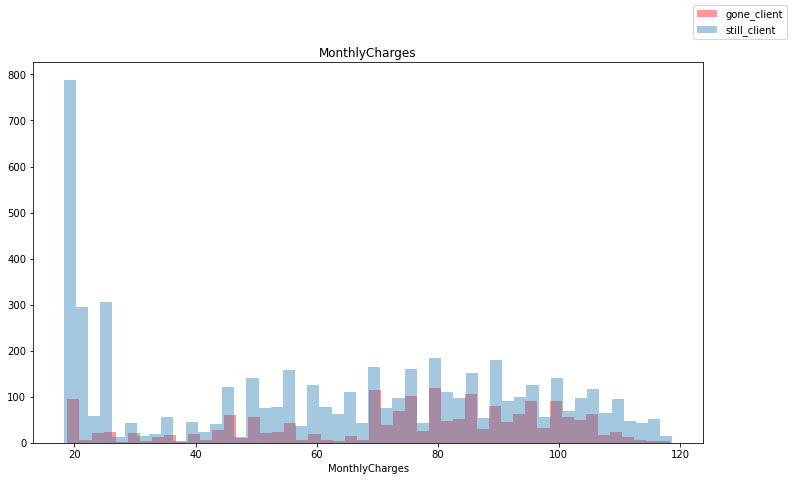

In [190]:
# Распределение абонентской платы
hist(gone_client, still_client, 'MonthlyCharges')

*TotalCharges*

In [191]:
print('Статистика суммарной платы ушедших клиентов')
gone_client['TotalCharges'].describe()

Статистика суммарной платы ушедших клиентов


count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: TotalCharges, dtype: float64

In [192]:
print('Статистика суммарной платы действующих клиентов')
still_client['TotalCharges'].describe()

Статистика суммарной платы действующих клиентов


count    5174.000000
mean     2549.999497
std      2329.858843
min        18.800000
25%       572.900000
50%      1679.525000
75%      4262.850000
max      8672.450000
Name: TotalCharges, dtype: float64

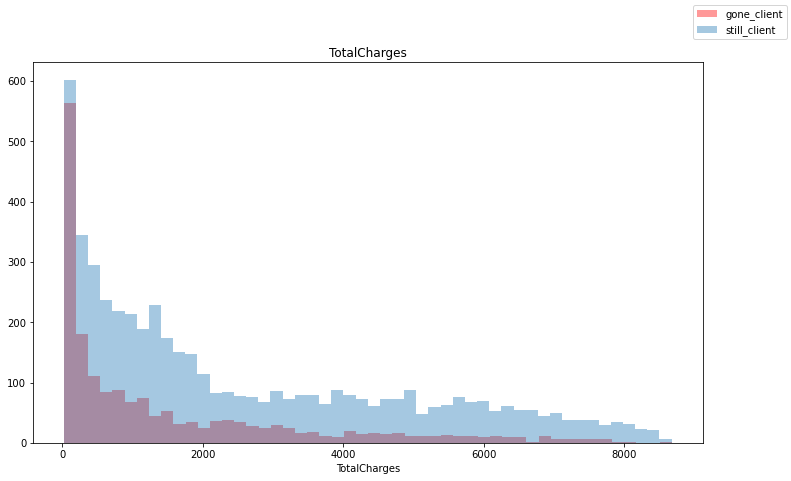

In [193]:
# Распределение суммарной платы
hist(gone_client, still_client , 'TotalCharges')

**Вывод по распределению оплаты:**
  - ежемесячная плата распределена не нормально. Средняя плата ушедших клиентов больше действующих
  - суммарная плата распределена не нормально. Средняя суммарная плата действующих клиентов значительно больше средней суммарной платы от действующих клиентов.

**Время жизни клиента**

In [194]:
# Добавляем столбец в датасет в днях
df_contract['lifetime'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days.astype('int')
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,lifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,123


In [195]:
# Для удобства выделим переменные с клиентами
gone_client = df_contract[df_contract['Churn']==1]
still_client = df_contract[df_contract['Churn']==0]

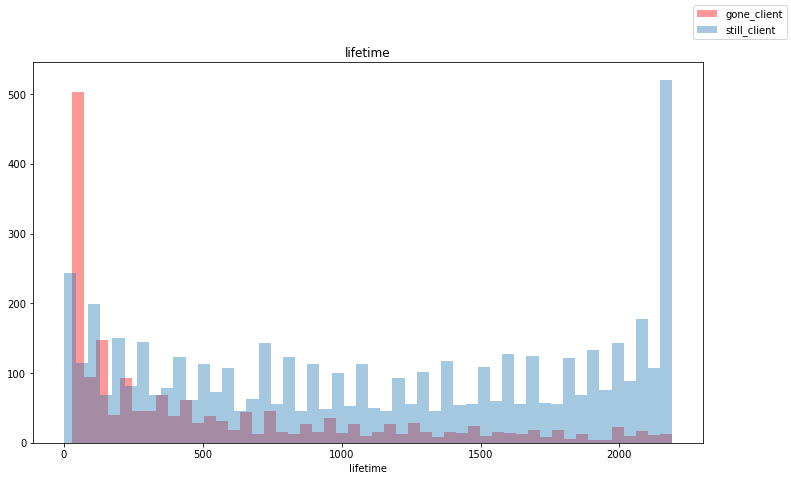

In [196]:
# Распределение времени жизни ушедших клиентов 
hist(gone_client , still_client , 'lifetime')

**Вывод по распределению времени жизни:**
- большАя часть клиентов уходит после пары месяцев от заключения договора. Примерно такое же количество среди действующих давних клиентов.

**Объединение признаков в один датасет**

In [197]:
def merging(df_1, df_2, df_3, df_4):
    df_full= df_1.merge(df_2, how = 'left', on = 'customerID')
    df_full = df_full.merge(df_3, how = 'left', on = 'customerID')
    df_full = df_full.merge(df_4, how = 'left', on = 'customerID')
    return df_full

In [198]:
df_full = merging(df_contract, df_personal, df_phone, df_internet)
df_full.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,lifetime,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [199]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   lifetime          7043 non-null   int32         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  MultipleLines     6361 n

**Заполнение пропусков после объединения**

Предполагаем, что отсутствие по клиенту информации об услугам интернета и телефона означает, что такими услугами он не пользуется, значит пропуски заполняем значение 'No'

In [200]:
df_full = df_full.fillna('No')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   lifetime          7043 non-null   int32         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  MultipleLines     7043 n

**Декодируем и масштабируем признаки**

In [201]:
def encoder(data):
    # Выделяем признаки, которые декодируем
    data_to_encode = data.select_dtypes(include = 'object').drop('customerID', axis=1) 
    data_not_encode = pd.concat([data['customerID'],
                                 data.select_dtypes(exclude= 'object')], axis =1)# датафрейм, которые не декодируем

        
    encoder = OneHotEncoder(drop='if_binary', sparse = False , dtype='int')    
    
    data_array = encoder.fit_transform(data_to_encode)    # Массив с категориями
    data_feature_names = encoder.get_feature_names(data_to_encode.columns.tolist())   # признаки, которые декодируем
    df_encoded = pd.DataFrame(data = data_array , columns = data_feature_names) # Эенкодированный датафрейм
        
   
    return pd.concat([data_not_encode, df_encoded] , axis=1)# возвращаем объединенный датафрейм

In [202]:
def scaler(data):
    num_columns = ['MonthlyCharges' , 'TotalCharges', 'lifetime']
    data_num =  data[num_columns]
    data_not_num = data.drop(num_columns , axis=1)
    
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data_num)
    df_num = pd.DataFrame(data = scaled , columns = num_columns)
    
    return  pd.concat([data_not_num, df_num] , axis=1)

In [203]:
#  Применение функций
df_encoded = encoder(df_full) 
df_encoded = scaler(df_encoded)


**Дополнительные признаки**

In [204]:
# Средняя стоимость клиента в день
df_encoded['avrg_client_cost'] = df_encoded['TotalCharges']/ df_encoded['lifetime']

# Клиенты, бывшие у нас 1мес
df_encoded.loc[df_encoded['lifetime']==0,'avrg_client_cost'] = df_encoded.loc[df_encoded['lifetime']==0, 'TotalCharges']/30

**Вывод по обработке признаков**
- для корректной работы алгоритмов для классовых признаков были применен OneHotEncoding(). В результате получены бинарные признаки.
- числовые признаки (время жизни клиента, оплата) отмасштабированы методом Standardscaler()
- добавлен признак 'стоимость клиента в день' 

## 4. Обучение модели

**Выделение признаков и целевого признака**

In [206]:
X = df_encoded.drop(['customerID','BeginDate', 'EndDate', 'Churn'] , axis=1)
y = df_encoded['Churn']

print('Размеры матрицы признаков и вектора целевого признака:')
X.shape , y.shape

Размеры матрицы признаков и вектора целевого признака:


((7043, 26), (7043,))

In [207]:
# Обучающие и тестовые данные
X_train, X_test, y_train , y_test = train_test_split(X, y , test_size = 0.2 , random_state = 12, stratify  = y)

In [208]:
print('Размеры обучающих данных:', X_train.shape , y_train.shape )
print('Размеры тестовых данных: ', X_test.shape , y_test.shape )


Размеры обучающих данных: (5634, 26) (5634,)
Размеры тестовых данных:  (1409, 26) (1409,)


In [209]:
def model_search(algorithm , params , distributions, X , y):
    model = algorithm(**params)
    selector = SelectKBest(f_classif)
    
    clf_selected = Pipeline([('selector' , selector) , ('model' , model)])

    clf = RandomizedSearchCV(clf_selected, 
                             distributions , 
                             random_state=12 , 
                             cv = 5 , 
                             scoring ='roc_auc', 
                             verbose=2,
                            n_jobs = -1)
    search = clf.fit(X, y)       # обучение
    y_pred = clf.predict(X)      # предсказанные метки классов
    proba = clf.predict_proba(X) # вероятности
    return {'best_score': search.best_score_,
            'best_estimator': search.best_estimator_,
            'best_predict': y_pred,
            'predict_proba': proba}

**Random Forest**

In [210]:
# Постоянные гиперпараметры
rf_params = {'n_jobs': 1,
             'random_state':12,
             'verbose': 0,   
             'class_weight':{0:1,1:3}}

# Переменные гиперпараметры
rf_distribs = {'model__max_depth': [4,6,8,10],
              'model__n_estimators' : [20, 40, 60, 80, 100,400],
              'model__max_features': [8,10,28],
              'selector__k': [5, 10, 15, 20 , 26]}


In [211]:
rf = model_search(RandomForestClassifier, rf_params, rf_distribs , X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.8s finished


In [212]:
rf

{'best_score': 0.8607843404161775,
 'best_estimator': Pipeline(steps=[('selector', SelectKBest()),
                 ('model',
                  RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=10,
                                         max_features=10, n_estimators=60,
                                         n_jobs=1, random_state=12))]),
 'best_predict': array([0, 0, 1, ..., 1, 1, 0]),
 'predict_proba': array([[1.        , 0.        ],
        [0.78466514, 0.21533486],
        [0.19823926, 0.80176074],
        ...,
        [0.31763605, 0.68236395],
        [0.21133477, 0.78866523],
        [0.68072714, 0.31927286]])}

**XG Boost**

In [213]:
# Постоянные гиперпараметры
xgb_params = {'random_state':12 , 'objective': 'binary:logistic' , 'scale_pos_weight':2.5 }

# Переменные гиперпараметры
xgb_distribs = {'model__max_depth': [4, 6, 8, 10],
                'model__learning_rate': [0.001, 0.01, 0.1, 0.2],
               'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               'model__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               'model__colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               'model__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
               'model__gamma': [ 0.5, 1.0 , 1.5],
               'model__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
               'model__n_estimators': [150 , 200, 300] , 
               'selector__k': [15, 20 , 26]              
               }

In [214]:
xgboost = model_search(XGBClassifier, xgb_params, xgb_distribs , X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.9s finished


In [215]:
xgboost

{'best_score': 0.8729900107864509,
 'best_estimator': Pipeline(steps=[('selector', SelectKBest(k=15)),
                 ('model',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=0.6, colsample_bynode=1,
                                colsample_bytree=0.4, gamma=1.5, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints='', learning_rate=0.2,
                                max_delta_step=0, max_depth=4,
                                min_child_weight=3.0, missing=nan,
                                monotone_constraints='()', n_estimators=150,
                                n_jobs=0, num_parallel_tree=1, random_state=12,
                                reg_alpha=0, reg_lambda=0.1,
                                scale_pos_weight=2.5, subsample=0.9,
                                tree_method='exact', validate_parameters=1,
                         

**LightGBM**

In [216]:
lgb_params = {'objective': 'binary' , 'metric': 'auc', 'neg_bagging_fraction':0.4, 'pos_bagging_fraction':1  }
lgb_distribs =  {'model__n_estimators': [400, 700, 1000],
                 'model__learning_rate': [0.001, 0.01, 0.12],
                 'model__colsample_bytree': [0.7, 0.8],
                 'model__max_depth': [4,6,8,10],
                 'model__num_leaves': [10, 20],
                 'model__reg_alpha': [1.1, 1.2],
                 'model__reg_lambda': [1.1, 1.2],
                 'model__min_split_gain': [0.3, 0.4],
                 'model__subsample': [0.8, 0.9],
                 'model__subsample_freq': [10, 20],
                 'selector__k': [15, 20 , 26]}

In [217]:
light_gbm = model_search(LGBMClassifier, lgb_params, lgb_distribs , X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.0s finished


In [218]:
light_gbm

{'best_score': 0.8838530512081828,
 'best_estimator': Pipeline(steps=[('selector', SelectKBest(k=15)),
                 ('model',
                  LGBMClassifier(colsample_bytree=0.8, learning_rate=0.12,
                                 max_depth=6, metric='auc', min_split_gain=0.3,
                                 n_estimators=400, neg_bagging_fraction=0.4,
                                 num_leaves=10, objective='binary',
                                 pos_bagging_fraction=1, reg_alpha=1.1,
                                 reg_lambda=1.2, subsample=0.8,
                                 subsample_freq=10))]),
 'best_predict': array([0, 0, 1, ..., 1, 1, 0]),
 'predict_proba': array([[0.83387839, 0.16612161],
        [0.98555669, 0.01444331],
        [0.11432059, 0.88567941],
        ...,
        [0.23446258, 0.76553742],
        [0.14936763, 0.85063237],
        [0.86441621, 0.13558379]])}

**CatBoost**

In [219]:
%%time
cat_params = {'random_state':12 , 'thread_count':-1 , 'class_weights': {0: 1, 1: 3}}

cat_distribs = {'model__depth':[2, 4, 6, 8, 10],
                #'model__bagging_temperature': [0,0.5,1,2],
                'model__random_strength': [0.5,1,1.5],
                'model__iterations':[1500],
                'model__learning_rate':[0.03,0.001,0.01,0.1], 
                'model__l2_leaf_reg':[3,1,5,10,100],
               # 'model__border_count':[32,5,10,20,50,100],     
             
                'selector__k': [5, 10, 15, 20 , 26]  }

Wall time: 0 ns


In [220]:
catboost = model_search(CatBoostClassifier, cat_params, cat_distribs , X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.4min finished


0:	learn: 0.6797487	total: 61.6ms	remaining: 1m 32s
1:	learn: 0.6636510	total: 73.9ms	remaining: 55.4s
2:	learn: 0.6512997	total: 79.5ms	remaining: 39.7s
3:	learn: 0.6410173	total: 84.5ms	remaining: 31.6s
4:	learn: 0.6329599	total: 88.3ms	remaining: 26.4s
5:	learn: 0.6220663	total: 93.2ms	remaining: 23.2s
6:	learn: 0.6156915	total: 96.8ms	remaining: 20.6s
7:	learn: 0.6073638	total: 102ms	remaining: 19.1s
8:	learn: 0.5995316	total: 106ms	remaining: 17.6s
9:	learn: 0.5917285	total: 112ms	remaining: 16.7s
10:	learn: 0.5850409	total: 117ms	remaining: 15.8s
11:	learn: 0.5790587	total: 122ms	remaining: 15.1s
12:	learn: 0.5706905	total: 127ms	remaining: 14.6s
13:	learn: 0.5651561	total: 132ms	remaining: 14s
14:	learn: 0.5595579	total: 140ms	remaining: 13.8s
15:	learn: 0.5552210	total: 143ms	remaining: 13.3s
16:	learn: 0.5530955	total: 146ms	remaining: 12.7s
17:	learn: 0.5494221	total: 150ms	remaining: 12.4s
18:	learn: 0.5467165	total: 153ms	remaining: 11.9s
19:	learn: 0.5409247	total: 165ms	r

174:	learn: 0.4159671	total: 1.31s	remaining: 9.96s
175:	learn: 0.4156349	total: 1.33s	remaining: 9.99s
176:	learn: 0.4156347	total: 1.33s	remaining: 9.94s
177:	learn: 0.4153775	total: 1.34s	remaining: 9.97s
178:	learn: 0.4152671	total: 1.35s	remaining: 9.94s
179:	learn: 0.4148982	total: 1.36s	remaining: 9.97s
180:	learn: 0.4147281	total: 1.36s	remaining: 9.94s
181:	learn: 0.4141932	total: 1.38s	remaining: 9.96s
182:	learn: 0.4139278	total: 1.39s	remaining: 9.99s
183:	learn: 0.4135329	total: 1.4s	remaining: 10s
184:	learn: 0.4132050	total: 1.41s	remaining: 10s
185:	learn: 0.4129351	total: 1.42s	remaining: 10s
186:	learn: 0.4120690	total: 1.42s	remaining: 10s
187:	learn: 0.4112832	total: 1.43s	remaining: 9.98s
188:	learn: 0.4109923	total: 1.44s	remaining: 10s
189:	learn: 0.4106332	total: 1.45s	remaining: 10s
190:	learn: 0.4106331	total: 1.46s	remaining: 9.98s
191:	learn: 0.4106331	total: 1.46s	remaining: 9.95s
192:	learn: 0.4102353	total: 1.47s	remaining: 9.94s
193:	learn: 0.4099207	tot

343:	learn: 0.3511424	total: 2.77s	remaining: 9.29s
344:	learn: 0.3506790	total: 2.78s	remaining: 9.3s
345:	learn: 0.3498725	total: 2.79s	remaining: 9.31s
346:	learn: 0.3492204	total: 2.8s	remaining: 9.31s
347:	learn: 0.3487768	total: 2.81s	remaining: 9.32s
348:	learn: 0.3483108	total: 2.83s	remaining: 9.32s
349:	learn: 0.3477831	total: 2.84s	remaining: 9.33s
350:	learn: 0.3473559	total: 2.85s	remaining: 9.33s
351:	learn: 0.3468133	total: 2.86s	remaining: 9.33s
352:	learn: 0.3463772	total: 2.88s	remaining: 9.34s
353:	learn: 0.3458537	total: 2.89s	remaining: 9.35s
354:	learn: 0.3453015	total: 2.9s	remaining: 9.35s
355:	learn: 0.3445465	total: 2.91s	remaining: 9.35s
356:	learn: 0.3440017	total: 2.92s	remaining: 9.35s
357:	learn: 0.3432456	total: 2.93s	remaining: 9.36s
358:	learn: 0.3427344	total: 2.94s	remaining: 9.36s
359:	learn: 0.3422977	total: 2.96s	remaining: 9.37s
360:	learn: 0.3419254	total: 2.97s	remaining: 9.37s
361:	learn: 0.3414047	total: 2.98s	remaining: 9.37s
362:	learn: 0.3

518:	learn: 0.2868169	total: 4.79s	remaining: 9.06s
519:	learn: 0.2865633	total: 4.8s	remaining: 9.06s
520:	learn: 0.2864342	total: 4.82s	remaining: 9.05s
521:	learn: 0.2862915	total: 4.83s	remaining: 9.04s
522:	learn: 0.2861280	total: 4.84s	remaining: 9.04s
523:	learn: 0.2859651	total: 4.85s	remaining: 9.03s
524:	learn: 0.2858344	total: 4.86s	remaining: 9.03s
525:	learn: 0.2855628	total: 4.87s	remaining: 9.02s
526:	learn: 0.2852931	total: 4.88s	remaining: 9.01s
527:	learn: 0.2851144	total: 4.89s	remaining: 9.01s
528:	learn: 0.2849490	total: 4.9s	remaining: 9s
529:	learn: 0.2845297	total: 4.92s	remaining: 9s
530:	learn: 0.2842562	total: 4.93s	remaining: 8.99s
531:	learn: 0.2841256	total: 4.94s	remaining: 8.98s
532:	learn: 0.2839230	total: 4.95s	remaining: 8.98s
533:	learn: 0.2836876	total: 4.96s	remaining: 8.97s
534:	learn: 0.2835277	total: 4.97s	remaining: 8.96s
535:	learn: 0.2832300	total: 4.98s	remaining: 8.96s
536:	learn: 0.2830483	total: 5s	remaining: 8.96s
537:	learn: 0.2827567	t

681:	learn: 0.2566213	total: 6.66s	remaining: 7.99s
682:	learn: 0.2564949	total: 6.67s	remaining: 7.98s
683:	learn: 0.2563193	total: 6.68s	remaining: 7.97s
684:	learn: 0.2561368	total: 6.69s	remaining: 7.96s
685:	learn: 0.2559702	total: 6.71s	remaining: 7.96s
686:	learn: 0.2558593	total: 6.72s	remaining: 7.95s
687:	learn: 0.2558027	total: 6.72s	remaining: 7.93s
688:	learn: 0.2556360	total: 6.73s	remaining: 7.92s
689:	learn: 0.2554876	total: 6.74s	remaining: 7.91s
690:	learn: 0.2553249	total: 6.75s	remaining: 7.91s
691:	learn: 0.2551126	total: 6.76s	remaining: 7.9s
692:	learn: 0.2550159	total: 6.77s	remaining: 7.89s
693:	learn: 0.2548799	total: 6.78s	remaining: 7.88s
694:	learn: 0.2547701	total: 6.79s	remaining: 7.87s
695:	learn: 0.2546032	total: 6.81s	remaining: 7.86s
696:	learn: 0.2544035	total: 6.82s	remaining: 7.85s
697:	learn: 0.2542753	total: 6.83s	remaining: 7.85s
698:	learn: 0.2541441	total: 6.84s	remaining: 7.84s
699:	learn: 0.2540669	total: 6.85s	remaining: 7.83s
700:	learn: 0

840:	learn: 0.2404861	total: 8.47s	remaining: 6.64s
841:	learn: 0.2403656	total: 8.48s	remaining: 6.63s
842:	learn: 0.2402852	total: 8.49s	remaining: 6.62s
843:	learn: 0.2402213	total: 8.5s	remaining: 6.61s
844:	learn: 0.2401299	total: 8.52s	remaining: 6.6s
845:	learn: 0.2400476	total: 8.53s	remaining: 6.59s
846:	learn: 0.2399597	total: 8.54s	remaining: 6.58s
847:	learn: 0.2398756	total: 8.55s	remaining: 6.57s
848:	learn: 0.2397849	total: 8.56s	remaining: 6.56s
849:	learn: 0.2397742	total: 8.56s	remaining: 6.55s
850:	learn: 0.2397082	total: 8.57s	remaining: 6.54s
851:	learn: 0.2396485	total: 8.58s	remaining: 6.53s
852:	learn: 0.2395865	total: 8.59s	remaining: 6.52s
853:	learn: 0.2394299	total: 8.6s	remaining: 6.51s
854:	learn: 0.2393388	total: 8.61s	remaining: 6.5s
855:	learn: 0.2392388	total: 8.62s	remaining: 6.49s
856:	learn: 0.2391369	total: 8.63s	remaining: 6.48s
857:	learn: 0.2390573	total: 8.65s	remaining: 6.47s
858:	learn: 0.2389506	total: 8.66s	remaining: 6.46s
859:	learn: 0.23

1006:	learn: 0.2304187	total: 10.2s	remaining: 5.01s
1007:	learn: 0.2303624	total: 10.2s	remaining: 5s
1008:	learn: 0.2303083	total: 10.3s	remaining: 4.99s
1009:	learn: 0.2302779	total: 10.3s	remaining: 4.98s
1010:	learn: 0.2302155	total: 10.3s	remaining: 4.97s
1011:	learn: 0.2300868	total: 10.3s	remaining: 4.96s
1012:	learn: 0.2300454	total: 10.3s	remaining: 4.95s
1013:	learn: 0.2299593	total: 10.3s	remaining: 4.94s
1014:	learn: 0.2299102	total: 10.3s	remaining: 4.93s
1015:	learn: 0.2298092	total: 10.3s	remaining: 4.92s
1016:	learn: 0.2297452	total: 10.3s	remaining: 4.91s
1017:	learn: 0.2297152	total: 10.3s	remaining: 4.9s
1018:	learn: 0.2296646	total: 10.4s	remaining: 4.89s
1019:	learn: 0.2296126	total: 10.4s	remaining: 4.88s
1020:	learn: 0.2295487	total: 10.4s	remaining: 4.87s
1021:	learn: 0.2294999	total: 10.4s	remaining: 4.86s
1022:	learn: 0.2294173	total: 10.4s	remaining: 4.85s
1023:	learn: 0.2293860	total: 10.4s	remaining: 4.84s
1024:	learn: 0.2293603	total: 10.4s	remaining: 4.8

1168:	learn: 0.2239414	total: 11.9s	remaining: 3.38s
1169:	learn: 0.2239241	total: 12s	remaining: 3.37s
1170:	learn: 0.2239080	total: 12s	remaining: 3.36s
1171:	learn: 0.2238737	total: 12s	remaining: 3.35s
1172:	learn: 0.2238335	total: 12s	remaining: 3.34s
1173:	learn: 0.2238069	total: 12s	remaining: 3.33s
1174:	learn: 0.2237669	total: 12s	remaining: 3.32s
1175:	learn: 0.2237304	total: 12s	remaining: 3.31s
1176:	learn: 0.2236883	total: 12s	remaining: 3.3s
1177:	learn: 0.2236507	total: 12s	remaining: 3.29s
1178:	learn: 0.2235927	total: 12.1s	remaining: 3.28s
1179:	learn: 0.2235755	total: 12.1s	remaining: 3.27s
1180:	learn: 0.2235448	total: 12.1s	remaining: 3.26s
1181:	learn: 0.2235294	total: 12.1s	remaining: 3.25s
1182:	learn: 0.2234965	total: 12.1s	remaining: 3.24s
1183:	learn: 0.2234528	total: 12.1s	remaining: 3.23s
1184:	learn: 0.2234303	total: 12.1s	remaining: 3.22s
1185:	learn: 0.2234106	total: 12.1s	remaining: 3.21s
1186:	learn: 0.2233852	total: 12.1s	remaining: 3.2s
1187:	learn: 

1332:	learn: 0.2195165	total: 13.7s	remaining: 1.71s
1333:	learn: 0.2194936	total: 13.7s	remaining: 1.7s
1334:	learn: 0.2194649	total: 13.7s	remaining: 1.69s
1335:	learn: 0.2194420	total: 13.7s	remaining: 1.68s
1336:	learn: 0.2194161	total: 13.7s	remaining: 1.67s
1337:	learn: 0.2193680	total: 13.7s	remaining: 1.66s
1338:	learn: 0.2193473	total: 13.7s	remaining: 1.65s
1339:	learn: 0.2193304	total: 13.7s	remaining: 1.64s
1340:	learn: 0.2193099	total: 13.7s	remaining: 1.63s
1341:	learn: 0.2192811	total: 13.8s	remaining: 1.62s
1342:	learn: 0.2192633	total: 13.8s	remaining: 1.61s
1343:	learn: 0.2192500	total: 13.8s	remaining: 1.6s
1344:	learn: 0.2192322	total: 13.8s	remaining: 1.59s
1345:	learn: 0.2192104	total: 13.8s	remaining: 1.58s
1346:	learn: 0.2191990	total: 13.8s	remaining: 1.57s
1347:	learn: 0.2191794	total: 13.8s	remaining: 1.56s
1348:	learn: 0.2191658	total: 13.8s	remaining: 1.55s
1349:	learn: 0.2191459	total: 13.8s	remaining: 1.54s
1350:	learn: 0.2191345	total: 13.8s	remaining: 1

1498:	learn: 0.2164409	total: 15.4s	remaining: 10.3ms
1499:	learn: 0.2164242	total: 15.4s	remaining: 0us


In [221]:
catboost

{'best_score': 0.9254589838909686,
 'best_estimator': Pipeline(steps=[('selector', SelectKBest(k=5)),
                 ('model',
                  <catboost.core.CatBoostClassifier object at 0x000000906F9879C8>)]),
 'best_predict': array([0, 0, 1, ..., 1, 1, 0], dtype=int64),
 'predict_proba': array([[0.97726475, 0.02273525],
        [0.99197548, 0.00802452],
        [0.01117047, 0.98882953],
        ...,
        [0.26440033, 0.73559967],
        [0.00938149, 0.99061851],
        [0.94503965, 0.05496035]])}

**Лучшая модель**

In [222]:
# Лучшая модель на обучающих данных 
best_model =catboost['best_estimator']

# Метки классов лучшей модели
y_pred = catboost['best_predict']

# Вероятности классов лучшей модели
y_score = catboost['predict_proba']

In [227]:
# Метрики
def metrics(y_true, y_pred , y_score):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    print('Precision score:' ,  round(precision,4))
    print('Recall score:   ', round(recall, 4))    
    print('Accuracy score: ', round(accuracy, 4)) 
    print('ROC-AUC score:  ', round(roc_auc, 4))     
 # Кривая ROC  
    # Вероятности классов 

    fpr , tpr , _ = roc_curve(y_true , y_score[:,1] , pos_label=1)
    
    plt.figure(figsize = (10,8))
    plt.plot(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
    plt.show()
    

Значения метрик на обучающих данных:
Precision score: 0.7569
Recall score:    0.8936
Accuracy score:  0.8956
ROC-AUC score:   0.895


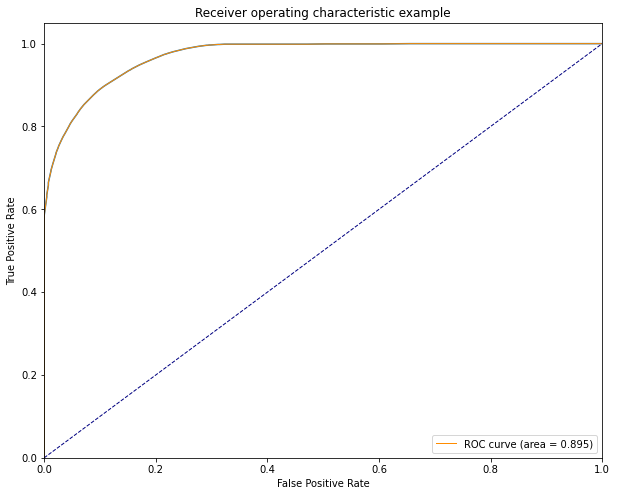

In [228]:
print('Значения метрик на обучающих данных:')
metrics(y_train, y_pred, y_score)


**Вывод по обучению и выбору модели:**
- выборка разделена 80% обучающих данных и  20% тестовых данных. Т.к. классы не сбалансированы выборки стратифицированные.
- для выбора признаков применен метод SelectKbest()
- рассмотрены модели Random Forest , бустинги: XGBoost, LightFBM , CatBoost.
- методом Randomizedsearch выполнен поиск гиперпараметров.
- на обучении (кроссвалидация на 5 фолдах) лучшее значение целевой метрики AUC ROC  показала модель CatBoost.

## 5. Тест модели

In [229]:
y_pred_test = best_model.predict(X_test)

y_score_test = best_model.predict_proba(X_test)

Precision score: 0.7293
Recall score:    0.7781
Accuracy score:  0.8644
ROC-AUC score:   0.8369


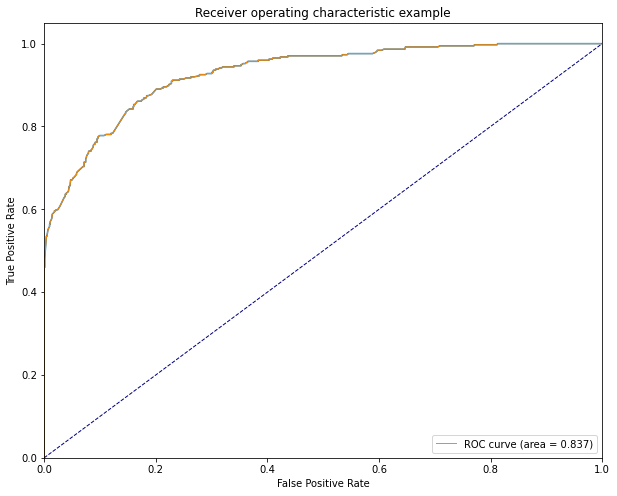

In [230]:
metrics(y_test, y_pred_test,y_score_test)

**Вывод по тесту модели:**
- на лучшей модели значение ROC AUC составляет 0.837


## 6. Отчет по работе